In [103]:
import requests, time, math
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [104]:
def getHistory(symbol):
    r = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + symbol + "&outputsize=full&apikey=A0P4")
    r = r.json()['Time Series (Daily)']
    hist = []
    dates = []
    for key in r.keys():
        dates.append(datetime.strptime(key, '%Y-%m-%d'))
        row = [float(x) for x in list(r[key].values())]
        hist.append(row)
    hist.reverse()
    dates.reverse()
    out = pd.DataFrame.from_records(hist, index = dates, columns = ["Open", "High", "Low", "Close", "Volume"])
    return out

In [105]:
wood = 'CUT'
gold = 'IAU'
market = 'SPY'

_wood = getHistory(wood)
_gold = getHistory(gold)
_market = getHistory(market)

In [106]:
minDate = max(_wood.index[0], _gold.index[0], _market.index[0])
wood = _wood[minDate:].resample('M').last()
gold = _gold[minDate:].resample('M').last()
market = _market[minDate:].resample('M').last()
wood.head()

,Open,High,Low,Close,Volume
2007-11-30,24.95,25.00,24.7700,24.80,15600.0
2007-12-31,24.30,24.30,24.2304,24.25,20867.0
2008-01-31,21.40,21.80,21.2500,21.80,12837.0
2008-02-29,23.01,23.01,21.7500,21.84,124100.0
2008-03-31,21.29,21.29,20.5300,21.01,62000.0


In [107]:
def addReturnsColumn(a):
    returns = pd.Series(index = a.index)
    returns.iloc[0] = 0
    for i in range(1, len(a.index)):
        date = a.index[i]
        returns[date] = 100*(a.iloc[i]['Close']-a.iloc[i-1]['Close'])/a.iloc[i-1]['Close']
    a['Returns'] = returns
    return a

wood = addReturnsColumn(wood)
gold = addReturnsColumn(gold)
market = addReturnsColumn(market)
wood.head()

,Open,High,Low,Close,Volume,Returns
2007-11-30,24.95,25.00,24.7700,24.80,15600.0,0.000000
2007-12-31,24.30,24.30,24.2304,24.25,20867.0,-2.217742
2008-01-31,21.40,21.80,21.2500,21.80,12837.0,-10.103093
2008-02-29,23.01,23.01,21.7500,21.84,124100.0,0.183486
2008-03-31,21.29,21.29,20.5300,21.01,62000.0,-3.800366


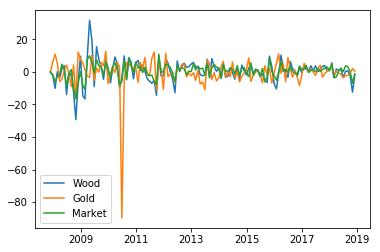

In [108]:
plt.figure()
plt.plot(wood.index, wood['Returns'].values)
plt.plot(gold.index, gold['Returns'].values)
plt.plot(market.index, market['Returns'].values)
plt.legend(["Wood", "Gold", "Market"])
plt.show()

In [109]:
#Get dates where wood out performs gold
long = []
short = []
for i in range(len(wood.index)):
    date = wood.index[i]
    if wood['Returns'][date] > gold['Returns'][date]:
        long.append(date)
    else:
        short.append(date)    

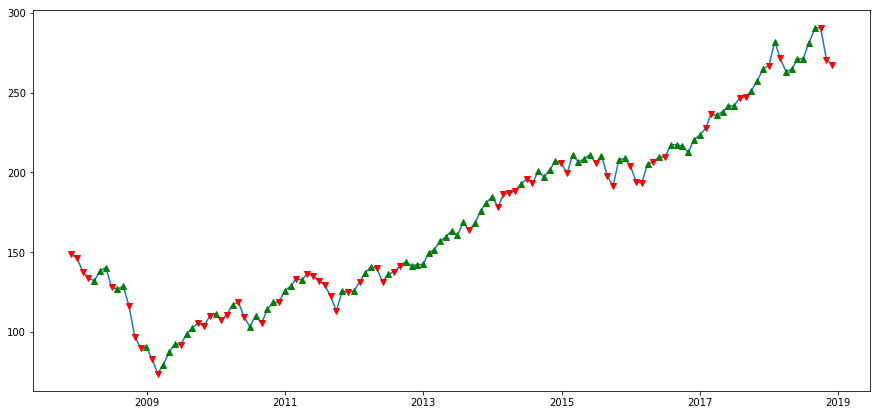

In [110]:
plt.figure(figsize = (15,7))
plt.plot(market.index, market['Close'].values)
plt.plot(long, [market['Close'][date] for date in long], 'g^')
plt.plot(short, [market['Close'][date] for date in short], 'rv')
plt.show()

In [111]:
portfolio = pd.DataFrame(index = market.index, columns = ["Cash", "Returns", "Cumulative Returns", "Drawdown"])
portfolio["Returns"].iloc[0] = 0
for i in range(len(market.index)-1):
    date = market.index[i]
    if wood['Returns'][date] > gold['Returns'][date]:
        portfolio["Returns"].iloc[i+1] = market["Returns"].iloc[i+1]
    else:
        portfolio["Returns"].iloc[i+1] = 0
portfolio.head()

,Cash,Returns,Cumulative Returns,Drawdown
2007-11-30,NaN,0,NaN,NaN
2007-12-31,NaN,0,NaN,NaN
2008-01-31,NaN,0,NaN,NaN
2008-02-29,NaN,0,NaN,NaN
2008-03-31,NaN,0,NaN,NaN


In [112]:
def addCumulativeReturnsColumn(a):
    creturns = pd.Series(index = a.index)
    creturns[a.index[0]] = 0
    for i in range(1, len(a.index)):
        creturns.iloc[i] = ((1+creturns.iloc[i-1]/100)*(1+a['Returns'].iloc[i]/100) - 1)*100
    a['Cumulative Returns'] = creturns
    return a

portfolio = addCumulativeReturnsColumn(portfolio)
market = addCumulativeReturnsColumn(market)

portfolio.head()

,Cash,Returns,Cumulative Returns,Drawdown
2007-11-30,NaN,0,0.0,NaN
2007-12-31,NaN,0,0.0,NaN
2008-01-31,NaN,0,0.0,NaN
2008-02-29,NaN,0,0.0,NaN
2008-03-31,NaN,0,0.0,NaN


In [113]:
def addCashColumn(a, startingCash):
    a['Cash'] = startingCash * (1+ a['Cumulative Returns']/100)
    return a
portfolio = addCashColumn(portfolio, 10000)
market = addCashColumn(market, 10000)
portfolio.head()

,Cash,Returns,Cumulative Returns,Drawdown
2007-11-30,10000.0,0,0.0,NaN
2007-12-31,10000.0,0,0.0,NaN
2008-01-31,10000.0,0,0.0,NaN
2008-02-29,10000.0,0,0.0,NaN
2008-03-31,10000.0,0,0.0,NaN


In [114]:
def addDrawdownColumn(a):
    max = a['Cash'].iloc[0]
    drawdown = pd.Series(index = a.index)
    for date in a.index:
        if a['Cash'][date] > max:
            max = a['Cash'][date]
        drawdown[date] = 100*(a['Cash'][date] - max)/max
    a['Drawdown'] = drawdown
    return a
portfolio = addDrawdownColumn(portfolio)
market = addDrawdownColumn(market)
portfolio.head()

,Cash,Returns,Cumulative Returns,Drawdown
2007-11-30,10000.0,0,0.0,0.0
2007-12-31,10000.0,0,0.0,0.0
2008-01-31,10000.0,0,0.0,0.0
2008-02-29,10000.0,0,0.0,0.0
2008-03-31,10000.0,0,0.0,0.0


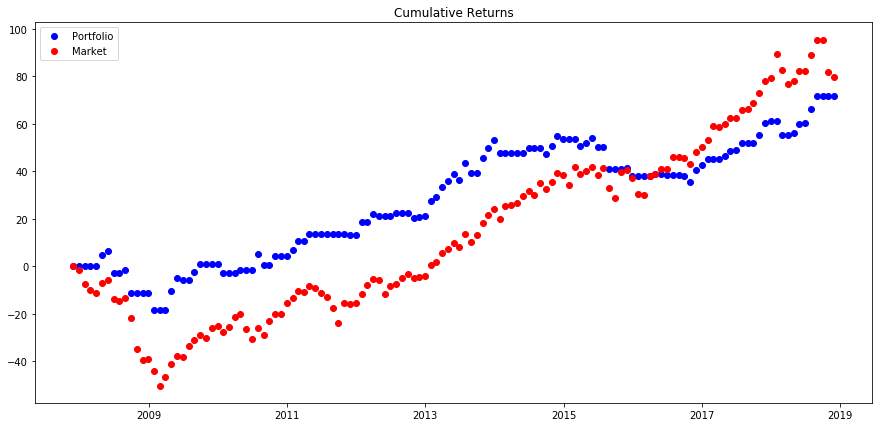

In [115]:
plt.figure(figsize = (15,7))
plt.plot(portfolio.index, portfolio['Cumulative Returns'].values, 'bo')
plt.plot(market.index, market['Cumulative Returns'].values, 'ro')
plt.legend(["Portfolio", "Market"])
plt.title("Cumulative Returns")
plt.show()

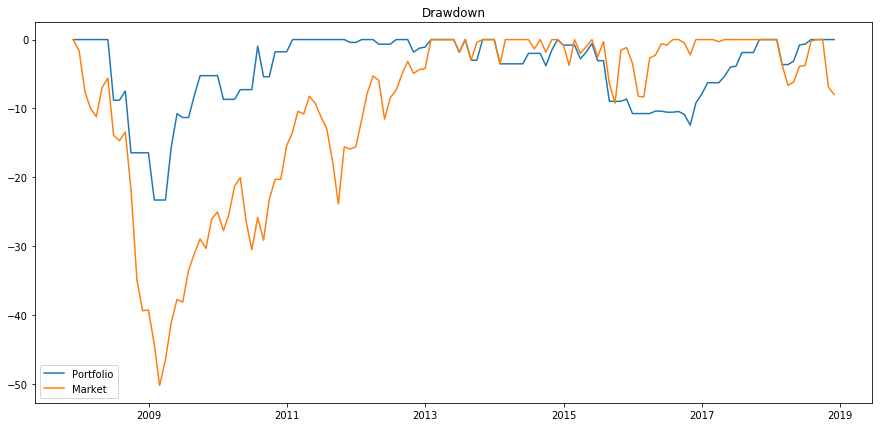

In [116]:
plt.figure(figsize = (15,7))
plt.plot(portfolio.index, portfolio['Drawdown'].values)
plt.plot(market.index, market['Drawdown'].values)
plt.legend(["Portfolio", "Market"])
plt.title("Drawdown")
plt.show()